In [1]:
# Import dataset and split
import pandas as pd

X = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250715_multitask_customXG/data/input_model1.csv')
y = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250715_multitask_customXG/data/output_model1.csv')

### Data Wrangler to drop material ID and one-hot-encode the space group and crystal structure categories

In [2]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X):
    # Drop column: 'material_id'
    X = X.drop(columns=['material_id'])
    return X

X_clean = clean_data(X.copy())
X_clean.head()

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,5-norm,7-norm,10-norm,lattice_a,lattice_b,lattice_c,alpha,beta,gamma,space_group_number
0,14.0,14.0,0.0,14.0,0.0,14.0,78.0,78.0,0.0,78.0,...,1.0,1.0,1.0,12.539835,12.336424,12.537087,77.158581,101.537034,106.471952,1
1,13.0,13.0,0.0,13.0,0.0,13.0,73.0,73.0,0.0,73.0,...,1.0,1.0,1.0,12.125311,12.276289,12.134424,99.886852,94.492749,84.943404,1
2,14.0,14.0,0.0,14.0,0.0,14.0,78.0,78.0,0.0,78.0,...,1.0,1.0,1.0,12.676976,12.182009,12.225709,80.759853,104.325951,78.831992,1
3,8.0,8.0,0.0,8.0,0.0,8.0,87.0,87.0,0.0,87.0,...,1.0,1.0,1.0,4.930603,5.122182,7.899177,90.627352,91.068696,90.120427,1
4,8.0,8.0,0.0,8.0,0.0,8.0,87.0,87.0,0.0,87.0,...,1.0,1.0,1.0,5.160296,5.240245,5.890213,90.235173,90.496808,90.257131,1


In [ ]:
obx = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250715_multitask_customXG/data/obelix_cleaned.csv')
obx_X = obx.drop(['Ionic conductivity (S cm-1)'] , axis = 1)
obx_X = obx_X[X_clean.columns]
obx_y = obx['Ionic conductivity (S cm-1)']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_clean, y, test_size= 0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.5,random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# For X (remains global)
scaler_X = StandardScaler()
X_train_sc = scaler_X.fit_transform(X_train)
X_val_sc = scaler_X.transform(X_val)
X_test_sc = scaler_X.transform(X_test)
obx_X_sc = scaler_X.transform(obx_X)

# For y (per-target)
scaler_y_dict = {}
y_train_scaled_list = []
y_val_scaled_list = []
y_test_scaled_list = []

for target in y_train.columns:
    scaler = StandardScaler()
    scaler.fit(y_train[[target]])  # Fit scaler on each individual target
    scaler_y_dict[target] = scaler

    y_train_scaled = scaler.transform(y_train[[target]])
    y_val_scaled = scaler.transform(y_val[[target]])
    y_test_scaled = scaler.transform(y_test[[target]])

    y_train_scaled_list.append(y_train_scaled)
    y_val_scaled_list.append(y_val_scaled)
    y_test_scaled_list.append(y_test_scaled)

# Combine back
y_train_sc = np.hstack(y_train_scaled_list)
y_val_sc = np.hstack(y_val_scaled_list)
y_test_sc = np.hstack(y_test_scaled_list)

In [6]:
# Tensoring the dataset
import torch
from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class InferenceDataset(Dataset):
    """
    For dataset containing only input, likely the Obelix CIF test file
    """
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

In [ ]:
# Dataloader
from torch.utils.data import DataLoader

train_dataset = DataSet(X_train_sc, y_train_sc)
val_dataset = DataSet(X_val_sc, y_val_sc)
test_dataset = DataSet(X_test_sc, y_test_sc)
obx_dataset = InferenceDataset(obx_X_sc)

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle= False, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle= False, drop_last = False)
obx_loader = DataLoader(obx_dataset, batch_size= 32, shuffle=False)

In [8]:
import torch.nn as nn

class GroupedMultiOutputRegressor(nn.Module):
    def __init__(self, input_dim, group_target_map):
        super().__init__()
        self.group_target_map = group_target_map  # Dict mapping group ➔ list of targets

        # Shared base layers
        self.shared_base = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )

        # Group-specific layers + heads (multi-output)
        self.group_layers = nn.ModuleDict()
        self.group_heads = nn.ModuleDict()

        for group, targets in group_target_map.items():
            self.group_layers[group] = nn.Linear(256, 128)
            self.group_heads[group] = nn.Linear(128, len(targets))  # Multi-output

        # Build mapping from target ➔ group + index
        self.target_info = {}
        for group, targets in group_target_map.items():
            for idx, target in enumerate(targets):
                self.target_info[target] = (group, idx)

    def forward(self, x):
        shared_out = self.shared_base(x)
        outputs = {}

        for group, layer in self.group_layers.items():
            group_out = torch.relu(layer(shared_out))
            group_preds = self.group_heads[group](group_out)  # (batch_size, num_targets_in_group)

            # Split outputs per target
            for idx, target in enumerate(self.group_target_map[group]):
                outputs[target] = group_preds[:, idx]

        return outputs


In [9]:
def masked_mse_loss(pred, target):
    mask = ~torch.isnan(target)
    if mask.sum() == 0:
        return torch.tensor(0.0, device=target.device)
    return nn.functional.mse_loss(pred[mask], target[mask])

def compute_total_loss(batch_outputs, batch_targets, target_groups):
    total_loss = 0.0
    for target_name in target_groups.keys():
        pred = batch_outputs[target_name]
        true = batch_targets[target_name]
        total_loss += masked_mse_loss(pred, true)
    return total_loss

In [10]:
def train(model, train_loader, val_loader, optimizer, target_groups, n_epochs=200):
    best_model_state = None
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            batch_outputs = model(X_batch)

            # Build batch_targets dictionary per target
            batch_targets = {
                target: y_batch[:, idx] for idx, target in enumerate(target_groups.keys())
            }

            # Compute total masked loss across all tasks
            loss = compute_total_loss(batch_outputs, batch_targets, target_groups)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                batch_outputs = model(X_batch)
                batch_targets = {
                    target: y_batch[:, idx] for idx, target in enumerate(target_groups.keys())
                }
                loss = compute_total_loss(batch_outputs, batch_targets, target_groups)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    print(f"\nBest Validation Loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_state)
    return model


In [11]:
import numpy as np
def test(model, test_loader, target_groups):
    model.eval()
    test_loss = 0.0
    all_preds = {target: [] for target in target_groups.keys()}
    all_targets = {target: [] for target in target_groups.keys()}

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            batch_outputs = model(X_batch)
            batch_targets = {
                target: y_batch[:, idx] for idx, target in enumerate(target_groups.keys())
            }
            loss = compute_total_loss(batch_outputs, batch_targets, target_groups)
            test_loss += loss.item()

            for target in target_groups.keys():
                all_preds[target].append(batch_outputs[target].cpu().numpy())
                all_targets[target].append(batch_targets[target].cpu().numpy())

    pred_dict = {target: np.concatenate(all_preds[target]) for target in target_groups.keys()}
    true_dict = {target: np.concatenate(all_targets[target]) for target in target_groups.keys()}

    return pred_dict, true_dict


In [12]:
def predict_only(model, inference_loader, target_groups):
    model.eval()
    all_preds = {target: [] for target in target_groups.keys()}

    with torch.no_grad():
        for X_batch in inference_loader:
            batch_outputs = model(X_batch)
            for target in target_groups.keys():
                all_preds[target].append(batch_outputs[target].cpu().numpy())

    predictions = {target: np.concatenate(all_preds[target]) for target in target_groups.keys()}
    return predictions


In [13]:
group_target_map = {
    'electronic': [
        'band_gap_x',
        'formation_energy_per_atom_x'
    ],
    'structural': [
        'mean Voro_index_10',
        'mean Voro_vol_mean',
        'density_x',
        'vpa'
    ],
    'topological': [
        'std_dev Voro_area_std_dev',
        'std_dev Voro_dist_mean',
        'mean Voro_dist_maximum',
        'std_dev Voro_dist_maximum'
    ],
    'dynamic': [
        'E_1D',
        'E_2D',
        'E_3D',
        'em_mean'
    ]
}

# Convert group_target_map (group ➔ targets) to target_groups (target ➔ group)
target_groups = {
    target: group
    for group, targets in group_target_map.items()
    for target in targets
}

model = GroupedMultiOutputRegressor(input_dim=X_train.shape[1], group_target_map=group_target_map)

# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
# 🚀 Run training
best_model = train(
    model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    target_groups=target_groups,  # critical
    n_epochs=100
)

Epoch 1: Train Loss = 8.2635 | Val Loss = 48232515.7671
Epoch 2: Train Loss = 7.4922 | Val Loss = 48232497.6891
Epoch 3: Train Loss = 7.2596 | Val Loss = 48232560.1823
Epoch 4: Train Loss = 7.0380 | Val Loss = 48232568.8127
Epoch 5: Train Loss = 6.9311 | Val Loss = 48232564.2508
Epoch 6: Train Loss = 6.7052 | Val Loss = 48232559.4381
Epoch 7: Train Loss = 6.5953 | Val Loss = 48232577.3566
Epoch 8: Train Loss = 6.5333 | Val Loss = 48232541.3913
Epoch 9: Train Loss = 6.4393 | Val Loss = 48232603.9652
Epoch 10: Train Loss = 6.3614 | Val Loss = 48232541.2951
Epoch 11: Train Loss = 6.1613 | Val Loss = 48232550.6529
Epoch 12: Train Loss = 6.2645 | Val Loss = 48232412.1210
Epoch 13: Train Loss = 6.1000 | Val Loss = 48232510.0448
Epoch 14: Train Loss = 5.8613 | Val Loss = 48232550.2283
Epoch 15: Train Loss = 5.9744 | Val Loss = 48232541.1813
Epoch 16: Train Loss = 5.8658 | Val Loss = 48232559.0234
Epoch 17: Train Loss = 5.8753 | Val Loss = 48232541.1816
Epoch 18: Train Loss = 5.8166 | Val Loss

In [15]:
# 🚀 Run evaluation (returns dict of predictions)
y_pred, y_true = test(
    best_model,
    test_loader,
    target_groups=target_groups
)

# 🚀 Run inference
obx_pred = predict_only(
    best_model,
    obx_loader,
    target_groups=target_groups
)

In [16]:
print(type(y_pred))
print(y_pred.keys() if isinstance(y_pred, dict) else 'Not a dict')

<class 'dict'>
dict_keys(['band_gap_x', 'formation_energy_per_atom_x', 'mean Voro_index_10', 'mean Voro_vol_mean', 'density_x', 'vpa', 'std_dev Voro_area_std_dev', 'std_dev Voro_dist_mean', 'mean Voro_dist_maximum', 'std_dev Voro_dist_maximum', 'E_1D', 'E_2D', 'E_3D', 'em_mean'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

band_gap_x — RMSE: 0.8376, R²: 0.6944
formation_energy_per_atom_x — RMSE: 0.3056, R²: 0.9252
mean Voro_index_10 — RMSE: 0.2312, R²: 0.2004
mean Voro_vol_mean — RMSE: 56065671168.0000, R²: -216010016917993699549413155799040.0000
density_x — RMSE: 0.0218, R²: -521838268.1252
vpa — RMSE: 4.9314, R²: 0.6989
std_dev Voro_area_std_dev — RMSE: 19855977742336.0000, R²: 0.7531
std_dev Voro_dist_mean — RMSE: 0.0940, R²: 0.5766
mean Voro_dist_maximum — RMSE: 0.1124, R²: 0.9663
std_dev Voro_dist_maximum — RMSE: 0.1357, R²: 0.7809
E_1D — RMSE: 0.3490, R²: 0.7555
E_2D — RMSE: 0.4380, R²: 0.7745
E_3D — RMSE: 1.3452, R²: 0.6749
em_mean — RMSE: 0.7284, R²: 0.6069

Average RMSE: 1422288748544.0000
Average R²: -15429286922713834717043876691968.0000


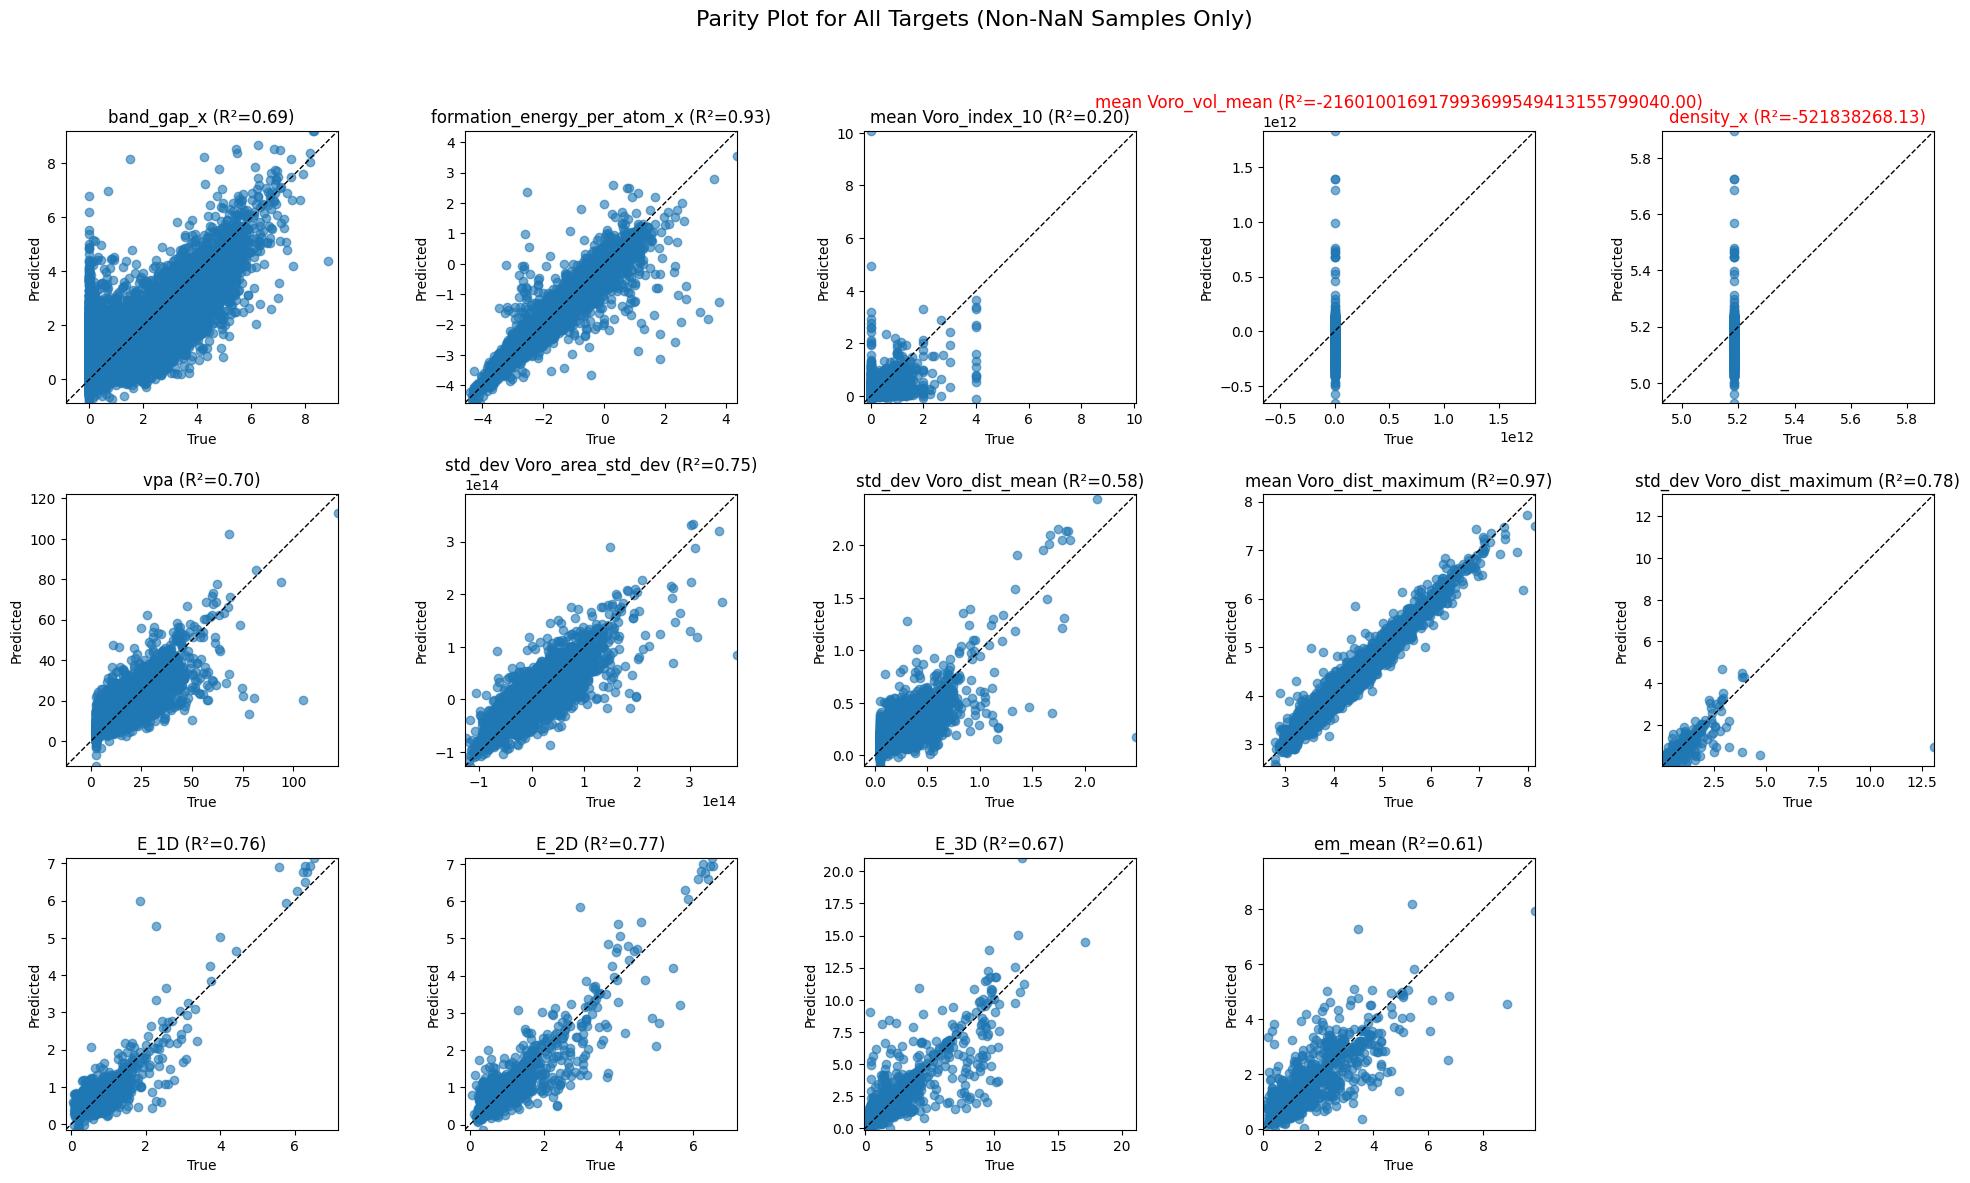

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Prepare evaluation storage
evaluation_results = {}

# Evaluate RMSE and R² per target
for target_name in y_pred.keys():
    y_true_target = y_true[target_name]
    y_pred_target = y_pred[target_name]

    # Inverse transform
    scaler = scaler_y_dict[target_name]
    y_true_orig = scaler.inverse_transform(y_true_target.reshape(-1, 1)).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_target.reshape(-1, 1)).flatten()

    # Mask NaNs: evaluate only where ground truth exists
    mask = ~np.isnan(y_true_orig) & ~np.isnan(y_pred_orig)
    y_true_valid = y_true_orig[mask]
    y_pred_valid = y_pred_orig[mask]

    # Skip evaluation if entire target is missing
    if len(y_true_valid) == 0:
        print(f"{target_name} — skipped (only NaNs in target)")
        continue

    # Compute metrics
    rmse = mean_squared_error(y_true_valid, y_pred_valid, squared=False)
    r2 = r2_score(y_true_valid, y_pred_valid)

    evaluation_results[target_name] = {
        'RMSE': rmse,
        'R2': r2,
        'y_true': y_true_valid,
        'y_pred': y_pred_valid
    }

    print(f"{target_name} — RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Summary
rmse_list = [res['RMSE'] for res in evaluation_results.values()]
r2_list = [res['R2'] for res in evaluation_results.values()]
print(f"\nAverage RMSE: {np.mean(rmse_list):.4f}")
print(f"Average R²: {np.mean(r2_list):.4f}")

# Parity Plots
n_targets = len(evaluation_results)
n_cols = 5
n_rows = int(np.ceil(n_targets / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()
fig.suptitle("Parity Plot for All Targets (Non-NaN Samples Only)", fontsize=16)

for i, (target_name, res) in enumerate(evaluation_results.items()):
    y_true_valid = res['y_true']
    y_pred_valid = res['y_pred']
    r2 = res['R2']

    ax = axes[i]
    ax.scatter(y_true_valid, y_pred_valid, alpha=0.6)
    min_val = min(y_true_valid.min(), y_pred_valid.min())
    max_val = max(y_true_valid.max(), y_pred_valid.max())

    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal')

    title_color = 'red' if r2 < 0 else 'black'
    ax.set_title(f"{target_name} (R²={r2:.2f})", color=title_color)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")

# Remove unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [22]:
# Obelix: Numpy to pandas
obx_X_df = pd.DataFrame(obx_X_sc, columns= obx_X.columns)
obx_pred_df = pd.DataFrame(obx_pred, columns=y.columns )

## Model 2: predict obelix struct descs and predict the IC value (599)

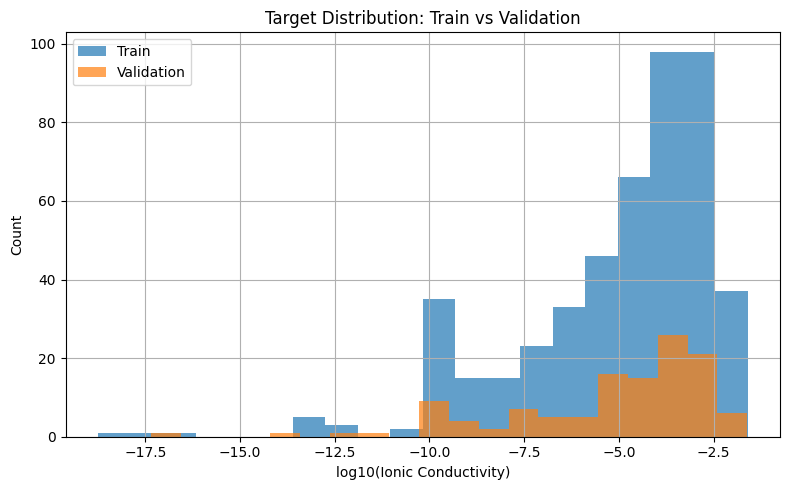

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming df_comp and df_struct are your two input dataframes
# Concatenate them by columns
X = pd.concat([obx_X_df.reset_index(drop=True), obx_pred_df.reset_index(drop=True)], axis=1)
y = obx_y

# log-scaling IC
import numpy as np
ic_log = np.log10(y)

# Data split
## custom binning
bin_edges = [-np.inf, np.inf]
y_bins = pd.cut(ic_log.values.flatten(), bins=bin_edges, labels=False)

## train-test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, ic_log, test_size=0.2, random_state=42, stratify=y_bins)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=20, alpha=0.7, label='Train', color='tab:blue')
plt.hist(y_val, bins=20, alpha=0.7, label='Validation', color='tab:orange')
plt.xlabel('log10(Ionic Conductivity)')
plt.ylabel('Count')
plt.title('Target Distribution: Train vs Validation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
X_train = X_train.fillna(0)  # Or other imputation method
y_train = y_train.fillna(y_train.median())

In [25]:
import smogn

# Convert to dataframe with target named explicitly as 'IC'
train_df = X_train.copy()
train_df['IC'] = y_train.values

# Apply SMOGN to oversample low IC region
train_df_smogn = smogn.smoter(
    data=train_df,
    y='IC',
    rel_thres=0.4,         # Focus on low IC region
    rel_method='auto',     # 'auto' or manually define relevance function
    k=5,                   # Number of nearest neighbors (can be tuned)
    samp_method='extreme', # Focus sampling near extremes
    under_samp=True        # Helps in balancing by also under-sampling majority
)

#Extract oversampled X and y
X_train_smogn = train_df_smogn.drop(columns=['IC'])
y_train_smogn = train_df_smogn['IC']


r_index: 100%|##########| 79/79 [00:00<00:00, 293.49it/s]


log_RMSE: 1.4315
log_R² Score: 0.7279
RMSE: 0.0015
R² Score: 0.6939


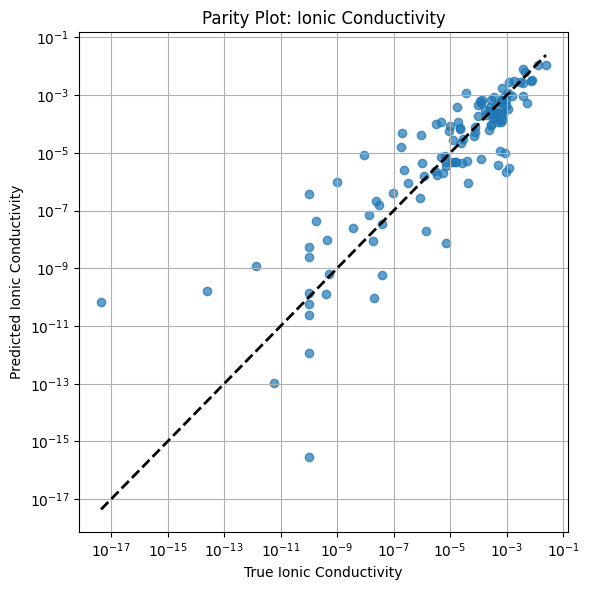

In [27]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Logarithmic weights to emphasize low IC without exploding
weights = np.log10(10 / (10**y_train_smogn + 1e-13))

# Clip to control maximum weight (adjust as needed)
weights = np.clip(weights, 1, 500)

# Initialize and train model
model = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train_smogn, y_train_smogn.values.ravel(), sample_weight=weights)

# Predict (still in log10 scale)
y_pred_log = model.predict(X_val)

# Evaluate on log scale
rmse_log = root_mean_squared_error(y_val, y_pred_log)
r2_log = r2_score(y_val, y_pred_log)
print(f"log_RMSE: {rmse_log:.4f}")
print(f"log_R² Score: {r2_log:.4f}")

# Inverse-transform for real-world scale evaluation
y_pred = 10**y_pred_log
y_true = 10**y_val

rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Parity Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.xlabel("True Ionic Conductivity")
plt.ylabel("Predicted Ionic Conductivity")
plt.title("Parity Plot: Ionic Conductivity")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


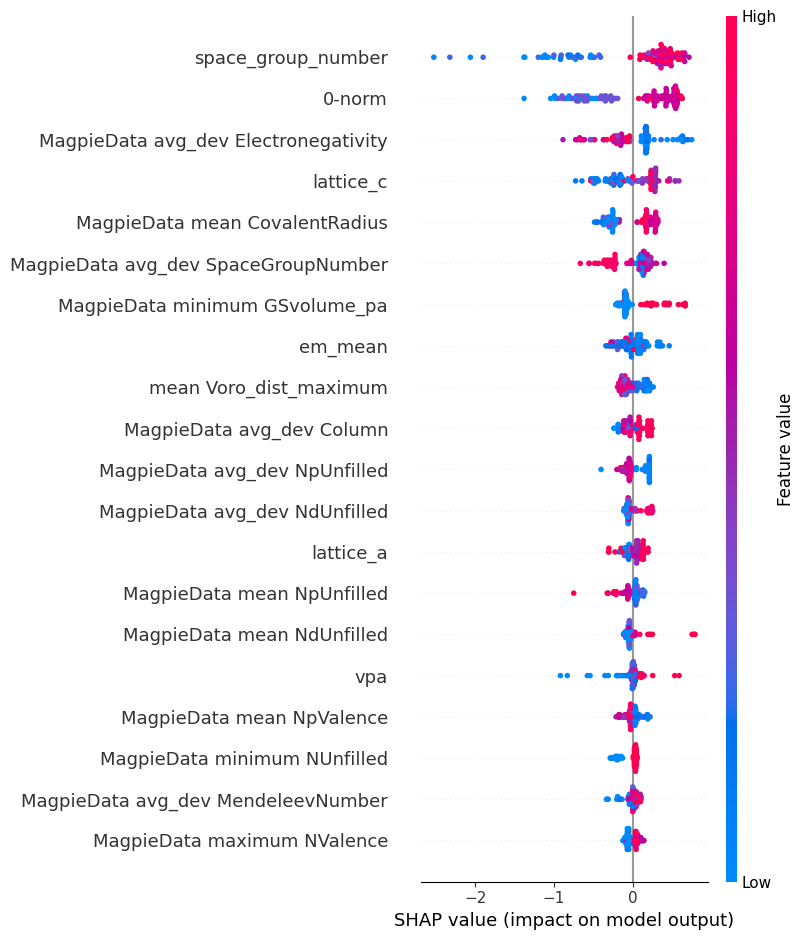

In [28]:
import shap

# Ensure X_val_sc is a DataFrame with column names
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# SHAP explainer for XGBoost
explainer = shap.Explainer(model, X_val_df)
shap_values = explainer(X_val_df)

# SHAP summary plot
shap.summary_plot(shap_values, X_val_df)

# Optional: Save summary plot
# import matplotlib.pyplot as plt
# plt.savefig("shap_summary_plot.png", bbox_inches='tight')


In [29]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

def objective(trial):
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    model = XGBRegressor(**param)

    # 5-fold cross-validation RMSE on training data
    scores = cross_val_score(
        model, X_train, y_train.values.ravel(),
        cv=5,
        scoring=make_scorer(mean_squared_error, squared=False)  # RMSE
    )

    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best hyperparameters:", study.best_params)


[I 2025-07-15 16:17:30,006] A new study created in memory with name: no-name-9b86ee97-b882-4c42-9b09-b8dd6c828d06
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  w

Best hyperparameters: {'n_estimators': 832, 'max_depth': 8, 'learning_rate': 0.012735405515151848, 'subsample': 0.5247811022727747, 'colsample_bytree': 0.5134154046782342, 'min_child_weight': 6, 'gamma': 1.0385174916213864, 'reg_alpha': 0.26550015592290954, 'reg_lambda': 0.9118486199814885}


log_RMSE: 1.2274
log_R² Score: 0.8000
RMSE: 0.0017
R² Score: 0.6339


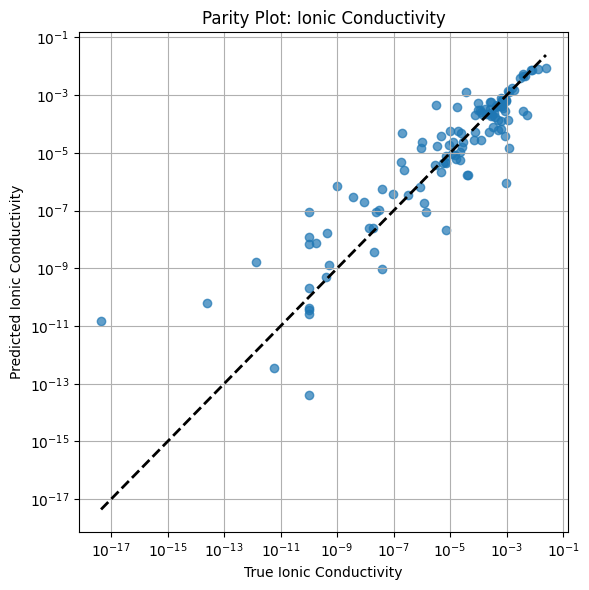

In [30]:
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train.values.ravel())

# Predict
y_pred_log = best_model.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred_log)
r2 = r2_score(y_val, y_pred_log)

print(f"log_RMSE: {rmse:.4f}")
print(f"log_R² Score: {r2:.4f}")

# Inverse transform for evaluation
y_pred = 10**y_pred_log
y_true = 10**y_val

y_true = y_true.values.flatten()
y_pred = y_pred.flatten()

rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.xlabel("True Ionic Conductivity")
plt.ylabel("Predicted Ionic Conductivity")
plt.title("Parity Plot: Ionic Conductivity")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

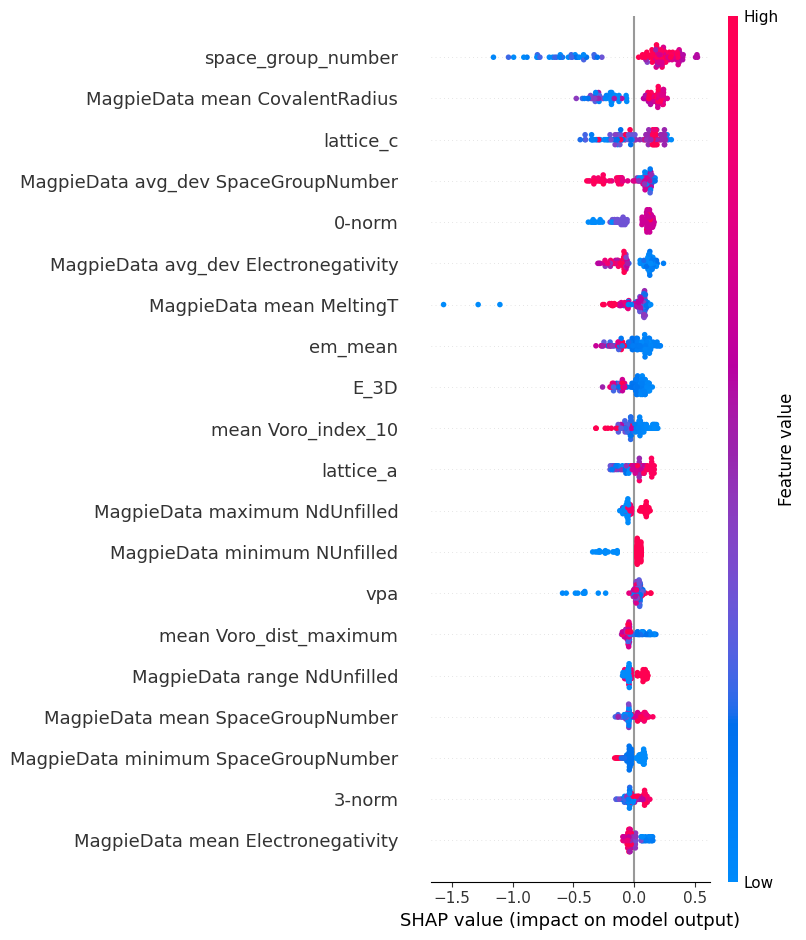

In [ ]:
import shap

# Ensure X_val_sc is a DataFrame with column names
X_val_df = pd.DataFrame(X_val, columns=X.columns)

# SHAP explainer for XGBoost
explainer = shap.Explainer(best_model, X_val_df)
shap_values = explainer(X_val_df)

# SHAP summary plot
shap.summary_plot(shap_values, X_val_df)

# Optional: Save summary plot
# import matplotlib.pyplot as plt
# plt.savefig("shap_summary_plot.png", bbox_inches='tight')

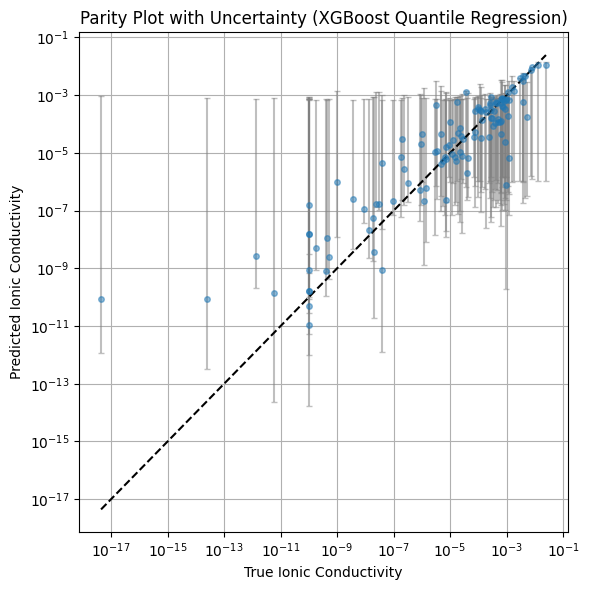

In [ ]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

# Train quantile models
best_model_lower = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.1, **study.best_params)
best_model_lower.fit(X_train, y_train.values.ravel())

best_model_upper = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.9, **study.best_params)
best_model_upper.fit(X_train, y_train.values.ravel())

best_model_median = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.5, **study.best_params)
best_model_median.fit(X_train, y_train.values.ravel())

# Predict log10 space
y_pred_lower_log = best_model_lower.predict(X_val)
y_pred_upper_log = best_model_upper.predict(X_val)
y_pred_median_log = best_model_median.predict(X_val)

# Convert back to normal space (ionic conductivity)
y_pred_lower = 10 ** y_pred_lower_log
y_pred_upper = 10 ** y_pred_upper_log
y_pred_median = 10 ** y_pred_median_log

# True values
y_true = 10 ** y_val.values.flatten()

# Compute asymmetric error bars
lower_error = y_pred_median - y_pred_lower
upper_error = y_pred_upper - y_pred_median

# Prevent negative errors (if quantile models overlap)
lower_error = np.maximum(lower_error, 1e-15)
upper_error = np.maximum(upper_error, 1e-15)

# Plot
plt.figure(figsize=(6, 6))
plt.errorbar(
    y_true,
    y_pred_median,
    yerr=[lower_error, upper_error],
    fmt='o',
    alpha=0.5,
    markersize=4,
    ecolor='gray',
    capsize=2
)

min_val = min(y_true.min(), y_pred_median.min())
max_val = max(y_true.max(), y_pred_median.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Ionic Conductivity')
plt.ylabel('Predicted Ionic Conductivity')
plt.title('Parity Plot with Uncertainty (XGBoost Quantile Regression)')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

Accuracy: 0.9667
ROC AUC:  0.9521


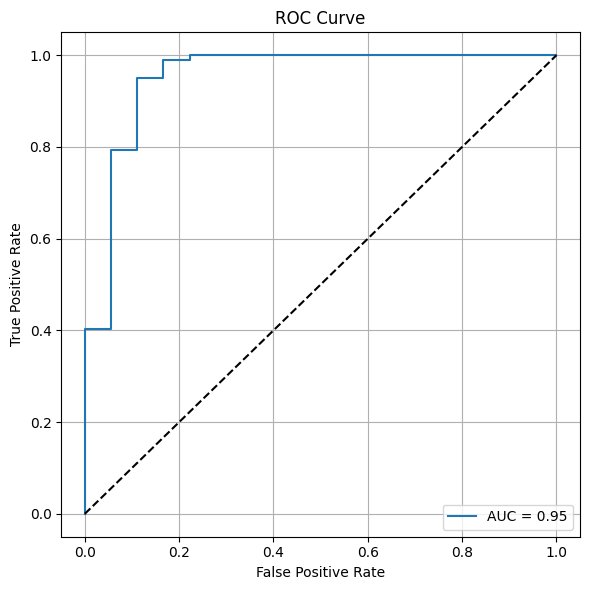

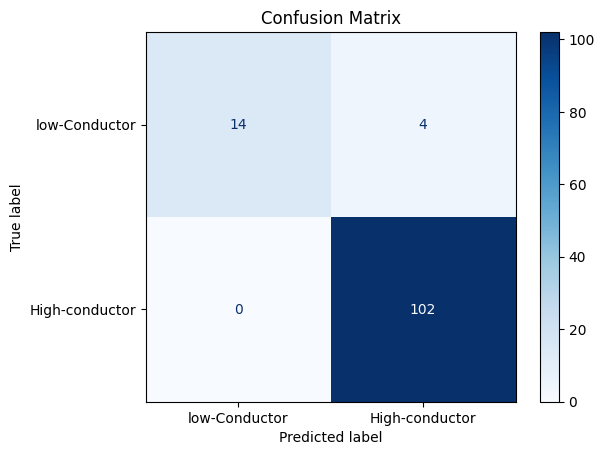

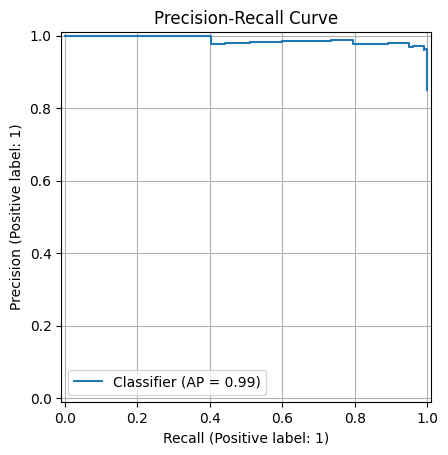

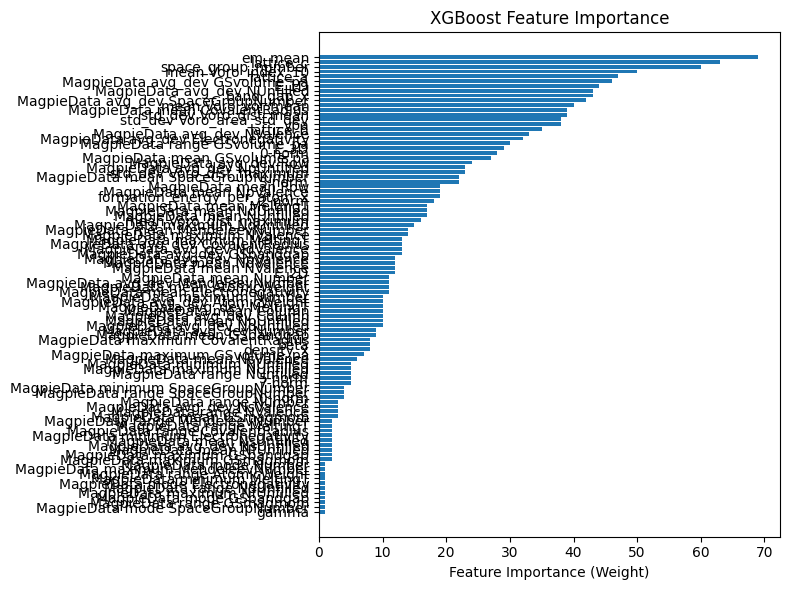

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay, PrecisionRecallDisplay
)

# STEP 1: Prepare Data
# X is your input features (already concatenated from obx_X_df and obx_pred_df)
# y is the ionic conductivity in S/cm (original scale)

# log-scale the conductivity
ic_log = np.log10(y.values.flatten())

# Create binary class labels based on 1e-8 S/cm threshold
y_class = (ic_log > -8).astype(int)  # 1 = conductor, 0 = non-conductor

# STEP 2: Train-Test Split (stratify for class balance)
X_train, X_val, y_train_class, y_val_class = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# STEP 3: Train XGBoost Classifier
clf_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf_model.fit(X_train, y_train_class)

# STEP 4: Predict Probabilities and Hard Labels
y_pred_proba = clf_model.predict_proba(X_val)[:, 1]  # Probability of being a conductor
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# STEP 5: Evaluate
accuracy = accuracy_score(y_val_class, y_pred_class)
roc_auc = roc_auc_score(y_val_class, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")

# STEP 6: ROC Curve
fpr, tpr, _ = roc_curve(y_val_class, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 7: Confusion Matrix
cm = confusion_matrix(y_val_class, y_pred_class)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-Conductor", "High-conductor"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# STEP 8: Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_val_class, y_pred_proba)
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# OPTIONAL: Feature Importance
xgb_importance = clf_model.get_booster().get_score(importance_type='weight')
xgb_importance = dict(sorted(xgb_importance.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8, 6))
plt.barh(list(xgb_importance.keys())[::-1], list(xgb_importance.values())[::-1])
plt.xlabel("Feature Importance (Weight)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()
